In [1]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""

import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked

import networkx
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops

from sklearn.model_selection import train_test_split

from tqdm import tqdm
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT


def train(model: torch.nn.Module, data: list[Data], optimizer, criterion):
    """
    Perform one training iteration of the model.

    Args:
        model ():
        data ():
        optimizer ():
        criterion ():

    Returns:

    """
    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    model.train()
    optimizer.zero_grad()
    out = model(*data_inputs)
    loss = criterion(out[data[0].train_mask], data[0].y[data[0].train_mask])
    loss.backward()
    optimizer.step()
    return loss


def evaluate_metrics(model: torch.nn.Module, data: list[Data], dataset: str = 'test') -> dict:
    """
    Calculate the different metrics for the specified dataset.

    Args:
        model (torch.nn.Module): The initiated model
        data (Data): The Torch dataset
        dataset (str): The dataset to specify the metrics for

    Returns:
        Dictionary with the metrics
    """
    if dataset == 'test':
        mask = data[0].test_mask
    elif dataset == 'train':
        mask = data[0].train_mask
    else:
        assert False, f'Dataset {dataset} not recognised. Should be "train" or "test".'
    model.eval()

    data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

    out = model(*data_inputs)
    pred = out

    metric_calculator = Metrics(pred[mask].detach().numpy(), data[0].y[mask].detach().numpy(),
                                threshold=0.5)
    metrics = metric_calculator.retrieve_all_metrics()

    return metrics


def plot_metrics_during_training(train_acc_all: list, test_acc_all: list, loss_all: list, model_name: str,
                                 metric_name: str, today, time):
    """
    Plot the evolution of metrics during training

    Args:
        train_acc_all (): the train score over epochs
        test_acc_all (): the test score over epochs
        model_name (): the name of the model

    Returns:
        None
    """


    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(1, len(train_acc_all) + 1), train_acc_all, label='Train accuracy', c='blue')
    ax1.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric_name)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss')
    ax2.plot(np.arange(1, len(train_acc_all) + 1), loss_all, label='Loss', c='green')

    plt.title(f'{model_name}')
    fig.legend(loc='lower right', fontsize='x-large')
    plt.grid()
    plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{model_name}_{metric_name}.png'))
    plt.show()


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


def get_mask(index: list, size: int) -> torch.Tensor:
    """
    Get a tensor mask of the indices that service as training and test

    Args:
        index ():
        size ():

    Returns:

    """

    mask = np.repeat([False], size)
    mask[index] = True
    mask = torch.tensor(mask, dtype=torch.bool)
    return mask


def make_torch_network(sampled_graph: networkx.classes.graph.Graph, embedding_df: pd.DataFrame,
                       processed_df: pd.DataFrame, train_mask: torch.Tensor, test_mask: torch.Tensor,
                       node_label_mapping: dict, embedding_type: str) -> Data:
    """
    Parse the networkx networks to a torch geometric format with node attributes

    Args:
        sampled_graph (networkx.classes.graph.Graph): A subsampled networkx graph
        embedding_df (pd.DataFrame): dataframe of standardised abstract embeddings
        processed_df (pd.DataFrame): dataframe with the labels
        train_mask (torch.Tensor): indices of train set
        test_mask (torch.Tensor): indices of test set
        node_label_mapping (dict): mapping between pui's and incremental reindexing

    Returns:
        graph dataset in torch geometric format
    """
    
    if embedding_type == 'general' or embedding_type == 'scibert':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                               embedding_df.columns.difference(['pui'])].astype(
                                                  np.float32).to_numpy()
    elif embedding_type == 'label_specific':
        node_features = embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                         embedding_df.columns.difference(['pui'])].to_numpy()
    
        reshaped_node_features = np.zeros((len(node_features), len(node_features[0])*len(node_features[0][0])), dtype=np.double)
        for idx, embedding in enumerate(node_features):
            reshaped_node_features[idx, :]  = np.vstack(embedding).flatten()
            
        node_features = (reshaped_node_features - reshaped_node_features.mean())/(reshaped_node_features.std())
        node_features = node_features.astype(np.double)

        # node_features = reshaped_node_features_std.tolist()
        
    # print(node_features)
    
    # set the node attributes (abstracts and labels) in the networkx graph for consistent processing later on
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(embedding_df.loc[embedding_df['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          node_features)), 'x')
    networkx.set_node_attributes(sampled_graph,
                                 dict(zip(label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                           'pui'].astype(str).to_list(),
                                          label_columns.loc[label_columns['pui'].isin(sampled_graph.nodes),
                                                            label_columns.columns.difference(['pui'])].astype(
                                              np.float32).to_numpy())), 'y')

    # would be nice if this one works, but it sadly doesn't
    # pyg_graph = from_networkx(sampled_graph)

    # x = embedding_df.loc[
    #         embedding_df['pui'].isin(sampled_graph.nodes), embedding_df.columns.difference(['pui'])].astype(np.float32).to_numpy()
    # y = label_columns.loc[
    #         label_columns['pui'].isin(sampled_graph.nodes), label_columns.columns.difference(['pui'])].astype(np.uint8).to_numpy()

    # set the ids at incremental integers.
    sampled_graph = networkx.relabel_nodes(sampled_graph, node_label_mapping)

    # get the x and the y from the networkx graph
    # TODO: enforce order of list for piece of mind
    x = np.array([emb['x'] for (u, emb) in sampled_graph.nodes(data=True)])
    y = np.array([emb['y'] for (u, emb) in sampled_graph.nodes(data=True)])
    edge_weights = np.array([attrs['weight'] for a, b, attrs in sampled_graph.edges(data=True)])

    # create the torch data object for further training
    data = Data(x=torch.from_numpy(x),
                edge_index=torch.from_numpy(np.array(sampled_graph.edges(data=False), dtype=np.int32).T),
                y=torch.from_numpy(y),
                train_mask=train_mask,
                test_mask=test_mask,
                edge_weight=edge_weights)
    
    data.edge_index = to_undirected(data.edge_index)
    data.edge_index, _ = add_remaining_self_loops(data.edge_index)

    return data


def standardise_embeddings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardise the abstract embeddings.
    Args:
        df (pd.DataFrame): dataframe with the embeddings

    Returns:
        standardised embeddings
    """
    df[df.columns.difference(['pui'])] = \
        (df[df.columns.difference(['pui'])] -
         df[df.columns.difference(['pui'])].mean()) / \
        df[df.columns.difference(['pui'])].std()
    return df


def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels,
                        heads=model_parameters['heads'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "dualGCN", "dualGAT", "SAGE"]'

    return model

In [2]:
# current models to choose from: ["GCN", "GAT", "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific"]

gnn_type = 'GraphTransformer'
subsample_size = 50000
data_type_to_use = ['author']
embedding_type = 'scibert'

all_model_parameters = {
    "GAT": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGCN": {
        'hidden_channels': 32
    },
}

In [3]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_20230413.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [4]:
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

In [6]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

print('Start processing data...')
print('Standardising embeddings...') 


# process the labels we want to select now

label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

# label_columns = processed_df.loc[:, ['pui', 'human', 'mouse', 'rat', 'nonhuman',
#                                      'controlled study', 'animal experiment']]
label_columns[label_columns.columns.difference(['pui'])] = label_columns[
    label_columns.columns.difference(['pui'])].astype(int)
features = ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization',
            'chemicals',
            'num_refs', 'date-delivered', 'labels_m', 'labels_a']

# drop all nodes that do not have an embedding
# nodes_to_remove = []
# for network in [author_networkx, keyword_network]:
#     nodes_to_remove += [node for node in list(network.nodes) if not node in embedding_df.pui.to_list()]
#
# for node in nodes_to_remove:
#     for network in [author_networkx, keyword_network]:
#         network.remove_node(node)

Start processing data...
Standardising embeddings...


/tmp/ipykernel_12959/1965970739.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_columns[label_columns.columns.difference(['pui'])] = label_columns[


In [7]:
label_columns.columns

Index(['pui', 'human', 'mouse', 'rat', 'nonhuman', 'controlled study',
       'animal experiment', 'animal tissue', 'animal model', 'animal cell',
       'major clinical study', 'clinical article', 'case report',
       'multicenter study', 'systematic review', 'meta analysis',
       'observational study', 'pilot study', 'longitudinal study',
       'retrospective study', 'case control study', 'cohort analysis',
       'cross-sectional study', 'diagnostic test accuracy study',
       'double blind procedure', 'crossover procedure',
       'single blind procedure', 'adult', 'aged', 'middle aged', 'child',
       'adolescent', 'young adult', 'very elderly', 'infant', 'school child',
       'newborn', 'preschool child', 'embryo', 'fetus', 'male', 'female',
       'human cell', 'human tissue', 'normal human', 'human experiment',
       'phase 2 clinical trial', 'randomized controlled trial',
       'clinical trial', 'controlled clinical trial', 'phase 3 clinical trial',
       'phase 1 cl

In [8]:
to_remove = [(a,b) for a, b, attrs in keyword_network.edges(data=True) if attrs["weight"] < 1/500]
keyword_network.remove_edges_from(to_remove)

In [54]:
len(list(set(embedding_df.pui.to_list())))

117310

In [56]:
print(len(list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.astype(str).to_list()))))
print(len(list(set(embedding_df.pui.astype(str).to_list()) & set(keyword_network.nodes))))

print(len(author_networkx.nodes))
print(len(keyword_network.nodes))
print(len(author_networkx.edges))
print(len(keyword_network.edges))

56337
96163
71727
97196
163133
913266


In [10]:
# get down-sampled networks
print('Sampling the graphs...')
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
print('keyword', len(set(keyword_network.nodes)))
print('author', len(set(author_networkx.nodes)))
print('embedding', len(set(embedding_df.pui.to_list())))

sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
node_label_mapping = dict(zip(sampled_author.nodes, range(len(sampled_author))))

Sampling the graphs...
keyword 97196
author 71727
embedding 117310


In [11]:
# create train and test split
print('Creating torch datasets...')
train_indices, test_indices = train_test_split(range(len(sampled_author)), test_size=0.2, random_state=0)
train_mask = get_mask(train_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = make_torch_network(sampled_author, embedding_df, processed_df, train_mask, test_mask,
                                 node_label_mapping, embedding_type)
keyword_data = make_torch_network(sampled_keyword, embedding_df, processed_df, train_mask, test_mask,
                                  node_label_mapping, embedding_type)

Creating torch datasets...


In [12]:
from torch_geometric.utils import contains_self_loops,is_undirected
is_undirected(author_data.edge_index)

True

In [37]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class ResidualConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(ResidualConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[-2]

class InitialConnection(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(InitialConnection, self).__init__()
        self.alpha = alpha

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        return Xs[-1] if len(Xs) == 1 else (1 - self.alpha) * Xs[-1] + self.alpha * Xs[0]
    
class DenseConnection(torch.nn.Module):
    def __init__(self, in_dim, out_dim, aggregation='concat'):
        super(DenseConnection, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.aggregation = aggregation
        if aggregation == 'concat':
            self.layer_transform = torch.nn.Linear(in_dim, out_dim, bias=True)
        elif aggregation == 'attention':
            self.layer_att = torch.nn.Linear(512, 1, bias=True)

    def forward(self, Xs: list):
        assert len(Xs) >= 1
        if self.aggregation == 'concat':
            X = torch.cat(Xs, dim=-1)
            X = self.layer_transform(X)
            return X
        elif self.aggregation == 'maxpool':
            X = torch.stack(Xs, dim=-1)
            X, _ = torch.max(X, dim=-1, keepdim=False)
            return X
        # implement with the code from https://github.com/mengliu1998/DeeperGNN/blob/master/DeeperGNN/dagnn.py
        elif self.aggregation == 'attention':
            # pps n x k+1 x c
            pps = torch.stack(Xs, dim=1)
            retain_score = self.layer_att(pps).squeeze()
            retain_score = torch.sigmoid(retain_score).unsqueeze(1)
            X = torch.matmul(retain_score, pps).squeeze()
            return X
        else:
            raise Exception("Unknown aggregation")

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_heads):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=num_heads))
        for i in range(2, num_layers):
            self.convs.append(GATv2Conv(hidden_channels*num_heads, hidden_channels, heads=num_heads))
        self.conv_last = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads)
        
        self.lin1 = torch.nn.Linear(hidden_channels*num_heads, out_channels)
        self.lin2 = torch.nn.Linear(out_channels, out_channels)
        self.sigmoid = torch.nn.Sigmoid()
        # self.skip_layers = DenseConnection(hidden_channels * num_heads * (num_layers-1), out_channels, aggregation='attention')
        self.skip_layers = InitialConnection(alpha=0.5)

        
    def forward(self, x, edge_index):
        xs = []
        x1 = F.dropout(torch.relu(self.convs[0](x, edge_index)), p=0.6, training=self.training)
        xs.append(x1)
        x_new = x1

        for i in range(self.num_layers - 2):
            x_new = F.dropout(torch.relu(self.convs[i+1](x_new, edge_index)), p=0.1, training=self.training)
            xs.append(x_new)
        x_last = self.skip_layers(xs)
        
        x = F.relu(self.lin1(x_last))
        x = self.lin2(x)
        x = self.sigmoid(x)

        return x

    
model = GNN(author_data.x.shape[1], 64, 52, 4, 4)

In [ ]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)

In [38]:
print(model)

GNN(
  (convs): ModuleList(
    (0): GATv2Conv(768, 64, heads=4)
    (1-2): 2 x GATv2Conv(256, 64, heads=4)
  )
  (conv_last): GATv2Conv(256, 52, heads=4)
  (lin1): Linear(in_features=256, out_features=52, bias=True)
  (lin2): Linear(in_features=52, out_features=52, bias=True)
  (sigmoid): Sigmoid()
  (skip_layers): InitialConnection()
)


In [69]:
label_data.x = label_data.x.T



In [ ]:
x_1

In [39]:
model.eval()


all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
print('This is the data object: ', data)
data_inputs = [d for data_object in data for d in (data_object.x, data_object.edge_index)]

# model.set_label_embeddings(*data_inputs[3:])

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())
# visualize(out, color=data.y.argmax(dim=1))

This is the data object:  [Data(x=[50000, 768], edge_index=[2, 182280], y=[50000, 52], train_mask=[50000], test_mask=[50000], edge_weight=[100042])]
The predictions of the test set before training:  [[0.5473698  0.49405667 0.4778985  ... 0.5211961  0.53186774 0.49421525]
 [0.552392   0.53962034 0.51252174 ... 0.49891967 0.5805677  0.5049098 ]
 [0.5467711  0.54741186 0.50098807 ... 0.5100494  0.5814321  0.5206793 ]
 ...
 [0.5302425  0.55398244 0.47837576 ... 0.5055673  0.5756306  0.49713957]
 [0.5300886  0.54162884 0.49148136 ... 0.54278857 0.55672973 0.5020065 ]
 [0.54931897 0.51805055 0.5030764  ... 0.5427443  0.56201756 0.4991541 ]]


In [40]:
# set training parameters
print('Start training procedure...')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# label_occs = label_columns[label_columns.columns.difference(['pui'])].sum().to_list()
# weight = torch.tensor(label_occs) / sum(label_occs)

criterion = torch.nn.BCELoss()
# criterion = torch.nn.MultiLabelSoftMarginLoss()

Start training procedure...


In [43]:
# train model
all_metrics = evaluate_metrics(model, data, dataset='train').keys()
train_metrics_all = {key: [] for key in all_metrics}
test_metrics_all = {key: [] for key in all_metrics}
loss_all = []

num_epochs = 300
for epoch in (pbar := tqdm(range(1, num_epochs))):
    loss = train(model, data, optimizer, criterion)

    train_metrics = evaluate_metrics(model, data, dataset='train')
    test_metrics = evaluate_metrics(model, data, dataset='test')

    for metric in train_metrics.keys():
        train_metrics_all[metric].append(train_metrics[metric])
        test_metrics_all[metric].append(test_metrics[metric])

    loss_all.append(loss.item())
    pbar.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(test_metrics)

Epoch: 299, Loss: 0.1299: 100%|██████████| 299/299 [17:37<00:00,  3.54s/it]

{'Precision': [0.5277777777777778, 0.7752449510097981, 0.6108262108262108, 0.590566037735849, 0.8066939890710383, 0.7431018078020932, 0.6889908256880733, 0.0, 0.8994614003590664, 0.7324561403508771, 0.7959183673469388, 0.6944444444444444, 0.6299810246679317, 0.0, 0.7512795684050353, 0.7218045112781954, 0.0, 1.0, 0.6818181818181818, 0.0, 0.8551020408163266, 0.0, 0.9494544952354648, 0.719047619047619, 0.875, 0.6781914893617021, 0.5384615384615384, 0.0, 0.7751849743881616, 0.8280418740346662, 0.7323943661971831, 0.29411764705882354, 0.6826280623608018, 0.0, 0.0, 0.8669014084507042, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.7777777777777778, 0.746031746031746, 0.6706312900274474, 0.0, 0.0, 0.819672131147541, 0.0, 0.0], 'Recall': [0.11838006230529595, 0.8263000852514919, 0.5063769485120454, 0.39720812182741116, 0.7883845126835781, 0.7319587628865979, 0.6839708561020036, 0.0, 0.8267326732673267, 0.4664804469273743, 0.5173010380622838, 0.19230769230769232, 0.25227963525835867, 

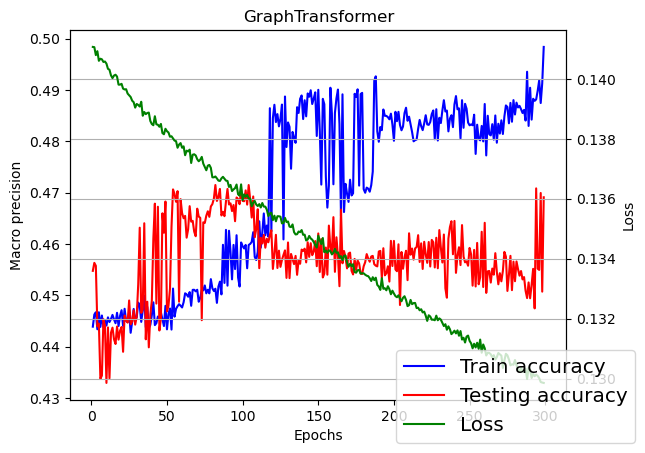

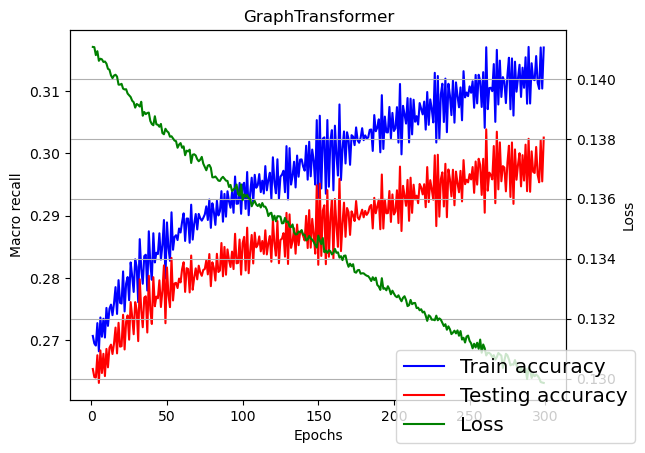

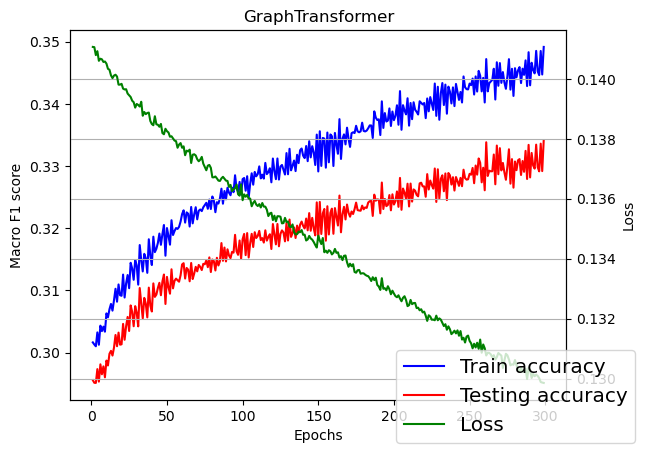

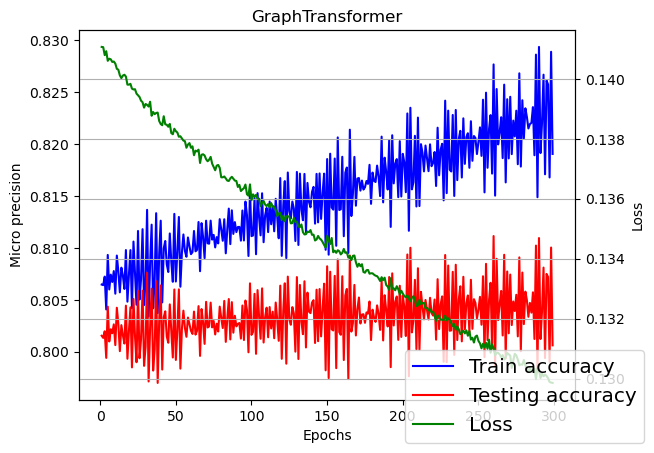

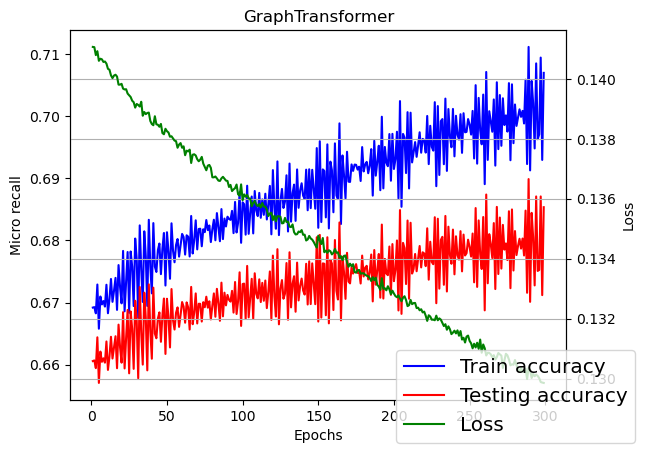

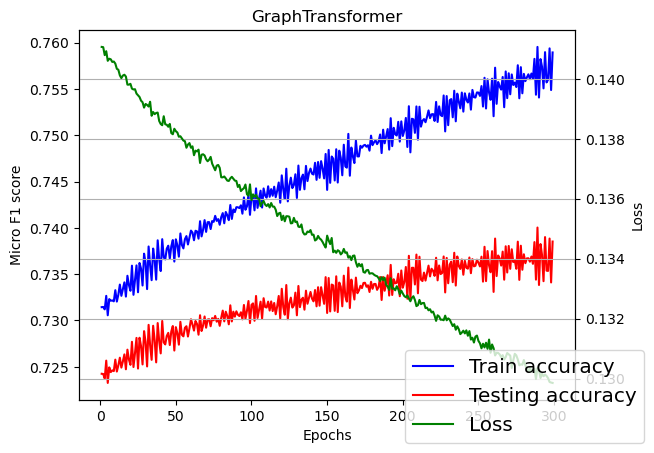

The predictions of the test set before training:  [[1.4344348e-03 1.0634475e-02 4.1544246e-03 ... 1.4244757e-03
  4.7833100e-04 5.3655147e-04]
 [8.9030825e-03 9.5342684e-01 2.0947909e-01 ... 5.8709545e-04
  4.9231672e-03 8.7553822e-02]
 [3.2466531e-02 8.4287483e-01 2.2060989e-01 ... 1.7811582e-04
  2.8961433e-02 2.8070644e-02]
 ...
 [9.0254573e-05 1.0456897e-03 3.1523098e-04 ... 5.0157686e-03
  3.6723915e-05 4.1176372e-05]
 [3.7883359e-03 5.9312329e-02 8.2303779e-03 ... 1.0420012e-03
  1.0333109e-03 3.7316778e-03]
 [1.4786228e-02 7.4531049e-01 5.2288586e-01 ... 7.9456996e-03
  6.7222260e-02 3.2127008e-02]]
Evaluating model performance...


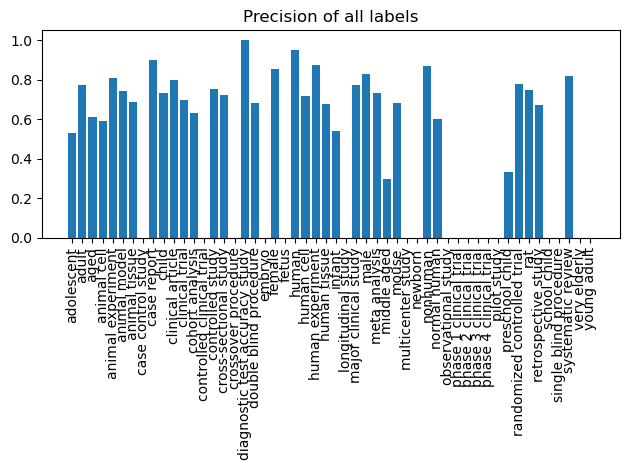

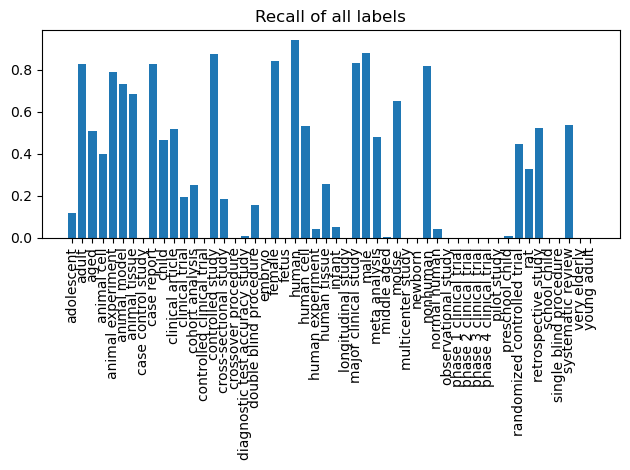

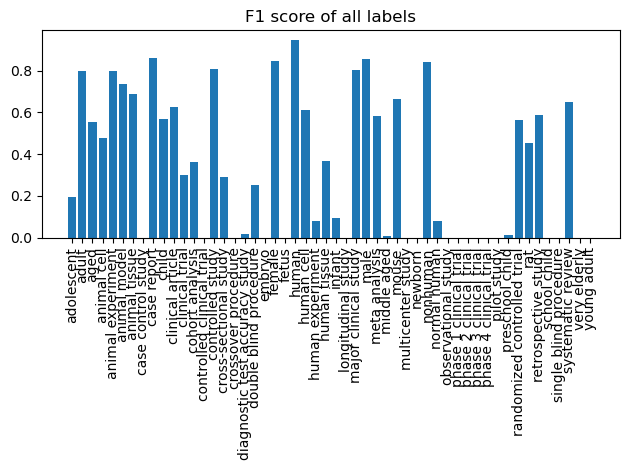

In [44]:
today = datetime.date.today()
now = datetime.datetime.now()
time = now.strftime("%H-%M-%S")

image_path = cc_path(f'reports/figures/classification_results/{today}/')
if not os.path.exists(image_path):
    os.mkdir(image_path)
os.mkdir(image_path + f'{time}/')
for metric in all_metrics:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(train_metrics_all[metric], test_metrics_all[metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)


# get output from trained model
model.eval()
out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().numpy())

# get the test accuracy
print('Evaluating model performance...')
train_end_metrics = evaluate_metrics(model, data, dataset='train')
test_end_metrics = evaluate_metrics(model, data, dataset='test')


for metric in all_metrics:
    if not 'Micro' in metric and not 'Macro' in metric:
        plt.figure()
        plt.title(f'{metric} of all labels')
        plt.bar(range(len(label_columns.columns.difference(['pui']))), test_end_metrics[metric], tick_label=label_columns.columns.difference(['pui']))
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(cc_path(f'reports/figures/classification_results/{today}/{time}/{gnn_type}_{metric}_label.png'))
        plt.show()

# print(f'Test Accuracy: {test_acc:.4f}')

# visualize(out, color=data.y.argmax(dim=1))

###### data_for_logreg_X, data_for_logreg_y = embedding_df.loc[embedding_df['pui'].isin(sampled_nodes), embedding_df.columns.difference(['pui'])].to_numpy(), \
                                       label_columns.loc[label_columns['pui'].isin(sampled_nodes), label_columns.columns.difference(['pui'])].to_numpy()

In [141]:
data_for_logreg_X_train, data_for_logreg_X_test = data_for_logreg_X[train_indices, :], data_for_logreg_X[test_indices, :]
data_for_logreg_y_train, data_for_logreg_y_test = data_for_logreg_y[train_indices, :], data_for_logreg_y[test_indices, :]

In [142]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as gbm

clf = OneVsRestClassifier(gbm.LGBMClassifier(n_jobs=-1, n_estimators=100))
clf = clf.fit(data_for_logreg_X_train, data_for_logreg_y_train)


In [143]:
y_test_pred = clf.predict(data_for_logreg_X_test)

In [144]:
from sklearn.metrics import f1_score
f1_score(data_for_logreg_y_test, y_test_pred, average='macro')

0.35458647168630447